# Rede convolucional para Redução de Ruídos em Imagens de Galáxias
- PET - Física
- Petiana: Ylana Karolina Santos Lopes
- Data: 22 de agosto de 2025

$\quad$Este `Notebook` tem como o objetivo treinar uma rede neural convulacional para retirar ruídos de imagens de galáxia do Sloan Digital Sky Server (SDSS). Utilizaremos a biblioteca `Pytorch` para montar uma rede do tipo U-Net com os dados do dataset Galaxy10. Ao longo deste trabalho será discutido a importância do tratamento dos ruídos em dados astronômicos, como também o funcionamento de redes convolucionais. Informamos que não será necessários conhecimentos prévios no assunto para acompanhar este trabalho, mas fica de indicação o `Notebook` *Classificação de galáxias usando Machine Learning* para mais informações.

O presente `Notebook` será organizado da seguinte forma:

1. *Introdução;*
2. *Ruído Sintético;*
3. *Rede Neural: Arquitetura U-Net e Treinamento;*
4. *Estatística;*
5. *Conclusão.*

$\quad$Para o leitor conseguir acompanhar o código, é necessário que sejam instaladas as bibliotecas utilizadas neste `Notebook`. Isto pode ser realizado utilizando o comando `python -m pip install` com os respectivos pacotes em uma janela de terminal.

**Obs.:** Treinar uma rede neural do zero tem um alto custo computacional, exigindo uma GPU para que os códigos rodem em uma escala de tempo não absurda. Caso o leitor não possua GPU (placa de vídeo), indico rodar este código na GPU do Google Colab. Para isso, basta alterar o tipo de ambiente de execução de CPU --> GPUs.

## Importando as bibliotecas

In [ ]:
import urllib.request
from tqdm import tqdm
import h5py
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader,random_split
import torch.nn.functional as F
import matplotlib.pyplot as plt
import warnings

%matplotlib inline
warnings.filterwarnings("ignore")

## Informações sobre as bibliotecas

In [ ]:
%load_ext version_information
%version_information matplotlib, numpy, torch, h5py

Software versions
Python 3.11.13 64bit [GCC 11.4.0]
IPython 7.34.0
OS Linux 6.1.123+ x86_64 with glibc2.35
matplotlib 3.10.0
numpy 2.0.2
torch 2.6.0+cu124
h5py 3.14.0
Mon Aug 18 16:38:17 2025 UTC

## 1.  Introdução

$\quad$A astronomia surgiu com o ser humano olhando para o céu e catalogando o que enxergava a olho nu. Assim, o pilar observacional da astronomia e astrofísica manteve e continua seu papel até hoje com instrumentos de escalas enormes tanto em terra quanto no espaço com o singelo objetivo de coletar dados de toda a parcela do Universo que nos é acessível. Todo esse campo de estudo depende fortemente dessas imagens astronômicas que carregam consigo informação sobre os mais diversos corpos celestes, comprovando modelos teóricos e fomentando novos. No entanto, esses dados são frequentemente corrompidos pela presença de ruídos atmosféricos e instrumentais levando a perca de informação importante, e dificultanto análises posteriores.

$\quad$Com o avanço da inteligência artificial, e de ferramentas como redes neurais convolucionais (CNNs), tornou-se possível aplicar técnicas automáticas para o tratamento dessas imagens. As CNNs são particularmente adequadas para tarefas de processamento de imagens devido à sua capacidade de extrair padrões espaciais e características relevantes. Neste trabalho, propomos a utilização de uma rede do tipo U-Net, uma arquitetura bastante utilizada em tarefas de segmentação e restauração de imagens, para reduzir ruídos em imagens de galáxias obtidas pelo Sloan Digital Sky Survey (SDSS). Utilizaremos o conjunto de dados Galaxy10, que oferece imagens reais de galáxias rotuladas, e a biblioteca PyTorch para o desenvolvimento e treinamento da rede neural.

$\quad$Primeiro passo é baixar o banco de dados que utilizaremos neste treinamento. O dataset escolhido foi o Galaxy10, que contém cerca de 21 mil imagens de forma 69 x 69 rotuladas. Os rótulos (labels) são geralmente utilizados em projetos de classificação. Como estamos montando um denoiser (uma rede para retirar ruído), os rótulos deste dataset não serão necessários aqui.

In [ ]:
urllib.request.urlretrieve("http://astro.utoronto.ca/~bovy/Galaxy10/Galaxy10.h5", "Galaxy10.h5")

with h5py.File('Galaxy10.h5', 'r') as U:
    images = np.array(U['images'])
    labels = np.array(U['ans'], dtype='int64')

print(f"Galaxy10 dataset: {len(images)} imagens e {len(np.unique(labels))} classes")

Galaxy10 dataset: 21785 imagens e 10 classes


## 2. Ruído Sintético

$\quad$Em astrofísica observacional, todos os dados adquiridos em observação *in situ* ou espaciais acabam sendo influenciados pela interação com os instrumentos, fazendo-se necessário passar um um processamento de imagem para tirar o que chamamos de ruído -- não carrega informação astrofísica -- e ajustar a estrutura dos dados para a finalidade específica da pesquisa. A etapa de redução do ruído visa limpar os dados de informação desnecessária proveniente do próprio instrumento por causa de flutuações de térmicas, detritos e poluição luminosa. Dessa forma, os dados finais contém a informação mais clara do objeto que está sendo observado, proporcionando análises mais precisas e confiáveis. Um indicativo do ruído nos dados é o chamado SNR (Signal to Noise Ratio) que traduz diretamente para fração do sinal para o ruído - quando maior o SNR melhor.

$\quad$Dois tipos de ruídos serão levados em conta neste trabalho: o ruído do próprio instrumento, geralmente um CCD (couple charged device) que tem natureza gaussiana; e o ruído fotônico, que se caracteriza como a flutuação na chegada dos fotóns no detector, obedecendo uma distribuição de Poisson. Como também a possibilidade de pixels queimados e saturados na imagem crua. Neste `Notebook`, estamos montando um banco de dados com ruído artificial tendo como base as imagens do Galaxy10 levando em conta os ruídos citados acima.

$\quad$Com isso em mente, criaremos a classe `Galaxy10ArrayDataset` com o intuito de retornar imagens do Galaxy10 com o ruído sintético. O ponto mais importante do bloco abaixo é a função `__getitem__` -- onde há o carregamento da imagem e o pré-processamento, retornando um par de imagens: uma limpa (a original) e uma com ruído artificial que acabamos de gerar.

In [ ]:
class Galaxy10ArrayDataset(Dataset):
    def __init__(self, images, labels=None, noise_std=0.1,
                 use_poisson=True, burn_ratio=0.01, saturate_ratio=0.01):
        self.images = images.astype(np.float32) / 255.0  # Normalização
        self.labels = labels
        self.noise_std = noise_std          # Ruído Gaussiano
        self.use_poisson = use_poisson      # Ruído de Poisson
        self.burn_ratio = burn_ratio        # fração de pixels queimados (0)
        self.saturate_ratio = saturate_ratio  # fração de pixels saturados (1)

    def __len__(self):
        return len(self.images) # Retorna o número total de imagens

    def __getitem__(self, idx):
        '''
        Nesta etapa, pegamos a imagem com índice `idx` e aplicamos as
        transformações na própria estrutura dos dados para alinhar com o input
        da função interpolate do Pytorch.
        '''
        img = self.images[idx]  # (69, 69, 3) - Dimensões da imagem, e número de canais (RGB)
        img = torch.tensor(img).permute(2, 0, 1)  # (Número de Canais, Altura, Largura)

        '''
        Redimensionamos a imagem de 69x69 para 128x128. Este passo é essencial para garantir
        o funcionamento correto das operações na arquitetura de rede escolhida (U-Net) que
        apresentam melhor desempenho com dimensões divisíveis por potências de 2 - devido a
        simetria das imagens.
        '''
        img = F.interpolate(img.unsqueeze(0), size=(128, 128), mode='bilinear', align_corners=False).squeeze(0)
        clean_img = img.clone()

        '''
        Assim, salvamos a imagem limpa (clean_img) e adicionamos o ruído gaussiano inicialmente
        '''
        noisy_img = clean_img + self.noise_std * torch.randn_like(clean_img)

        if self.use_poisson: # Aplica ruído de Poisson simulando contagens de fótons
            scale = 255.0
            img_poisson = torch.poisson(clean_img * scale) / scale
            noisy_img = (noisy_img + img_poisson) / 2.0  # média entre os ruídos


        '''
        Para adicionar os pixels queimados e saturados, montamos uma máscara aleatória
        que zera os pixels em todos os canais desse ponto (para um pixel queimado), e
        força o valor 1.0 (valor máximo, já que o intervalo válido é [0,1]) para simular um
        saturado.
        '''
        # Adiciona pixels queimados (0)
        burn_mask = torch.rand_like(noisy_img[0]) < self.burn_ratio
        for c in range(3):
            noisy_img[c][burn_mask] = 0.0

        # Adiciona pixels saturados (1)
        saturate_mask = torch.rand_like(noisy_img[0]) < self.saturate_ratio
        for c in range(3):
            noisy_img[c][saturate_mask] = 1.0

        # Retorna uma imagem com ruído sintético e uma limpa
        noisy_img = torch.clamp(noisy_img, 0.0, 1.0)
        return noisy_img, clean_img


$\quad$Podemos ver o resultado desse pré-processamento abaixo comparando a imagem original (limpa) com a correspondente contendo o ruído sintético que construímos, no painel de resultado do treinamento.

## 3. Rede Neural: Arquitetura U-Net

### 3.1 Rede Convulacional

$\quad$Apesar dos holofotes que as redes neurais vêm recebendo nos últimos anos, o uso desses algoritmos remonta ao século passado. As redes neurais convolucionais (CNNs – Convolutional Neural Networks) tiveram sua essência introduzida em 1980, com a publicação do Neocognitron por Kunihiko Fukushima [2], fortemente inspirado na biologia do cortex visual do ser humano. No entanto, essa abordagem só ganhou destaque no final dos anos 1990, quando Yann LeCun [3] apresentou a LeNet-5, uma CNN projetada para o reconhecimento de dígitos manuscritos. Hoje, com o avanço do poder computacional — especialmente com o uso de GPUs — é possível alcançar resultados de alto nível em tarefas complexas de visão computacional.

$\quad$Ao contrário das redes tradicionais, as CNNs são especializadas em processar dados que tenham uma topologia grid-like, o que inclui séries temporais (vistas como um grid de uma dimensão), e, o que usaremos aqui, dados em imagem que podem ser interpretados como um grid de duas dimensões. As CNNs são muito boas em reconhecer padrões independente das suas posições no input. Assim, se torna muito útil para detecção de objetos, reconhecimento facial, e para redução de ruídos.

$\quad$A palavra "convolucional" no nome desse tipo de rede indica o uso da operação matemática chamada convolução -- um tipo de operação linear. Matematicamente, no seu cerne, convolução é uma operação matemática que combina duas funções para formar uma terceira, que representa como a forma de uma foi modificada pela outra. A convolução é denotada pelo asterisco ($*$).

"_Redes convolacionais são simplesmente redes neurais que usam convolução no lugar da multiplicação geral de matrizes em pelo menos uma de suas camadas._" - Goodfellow et al, 2016 [4].

$\quad$Trazendo para o contexto das redes neurais, e de ruídos, podemos entender essa operação qualitativamente imaginando que estamos monitorando a posição de um búfalo ideal$^*$ com um sensor a laser. Este sensor nos retorna a posição $x(t)$ do búfalo para um tempo $t$, em que $x$ e $t$ são valores reais. Considerando que o nosso laser é ruidoso, precisamos de várias medidas para para poder estimar a posição do búfalo fazendo uma média delas. As medidas terão níveis de relevância diferentes (pesos), em que as mais recentes serão mais importantes. Com isso, chamamos $w(a)$ de função peso, em que $a$ é a idade da medida. Aplicando uma média ponderada com base na função $w(a)$, encontramos uma nova função $s(t)$ que nos retorna uma estimativa da posição do búfalo, como mostrado abaixo.

$$
s(t) = \int x(a) w(t - a)da \implies s(t) = (x * w)(t) \tag{3.1}
$$

$\quad$O primeiro argumento $x$ é chamado de _input_, já o segundo termo $w$ é o _kernel_. O resultado dessa operação (output) pode ser referido como _feature map_. Com isso, para fins computacionais (e mais realistas para o exemplo), podemos discretizar a expressão (1) para que o tempo assuma apenas valores inteiros positivos:

$$
 s(t) = (x * w)(t) = \sum_{a=-\infty}^{\infty}  x(a) w(t - a)da \tag{3.2}
$$

$\quad$Contudo, para as aplicações usando redes neurais, o _input_ geralmente está no formato de uma matriz multidimensional, e o _kernel_ também possui a forma de um array multidimensional (assume o nome de tensor daqui para frente) formado por parâmetros que são adaptados ao longo do aprendizado.
Para uma imagem $I$ com 2 dimensões como nosso _input_, nosso _kernel_ $K$ também adotará 2D, de forma que chegamos a

$$
S(i,j) = (I*K)(i,j) = \sum_{m}\sum_{n} I(m,n) K(i-m, j-n). \tag{3.3}
$$

$\quad$A convolução é comutativa, porque o kernel é invertido em relação ao _input_: à medida que o índice da entrada aumenta, o do kernel diminui. Essa característica não é essencial para as redes neurais, sendo mais questão de formalismo matemático. Dessa forma, várias bibliotecas implementam a correlação cruzada (_cross-correlation_), que funciona como a convolução, mas sem inversão dos kerneis []:

$$
S(i,j) = (I*K)(i,j) = \sum_{m}\sum_{n} I(m,n) K(i+m, j+n). \tag{3.4}
$$

O `PyTorch`, que usaremos aqui, implementa a correlação cruzada.

$\quad$Dessa forma, podemos criar as funções `visualize_feature_maps` e `plot_conv_weights` para visualizar o que acontece em cada camada da nossa rede neural, observando o _feature maps_ e o kernel de cada área da imagem.

$^*$ Tem 1 tonelada e corre a 400 km/h

In [ ]:
def plot_conv_weights(model):
    weights = model.down1[0].weight.data.cpu()  # Pesos da primeira camada convolucional
    n_kernels = weights.shape[0]
    fig, axes = plt.subplots(1, min(8, n_kernels), figsize=(15, 3))
    for i in range(min(8, n_kernels)):
        kernel = weights[i].permute(1, 2, 0)  # forma: [H, W, C]
        axes[i].imshow(kernel.numpy(), interpolation='nearest')
        axes[i].axis('off')
        axes[i].set_title(f'Kernel {i}')
    plt.tight_layout()
    plt.show()


def visualize_feature_maps(model, image_tensor):
    model.eval()
    with torch.no_grad():
        # Pega os features (característica) depois da primeira camada convolucional
        x = model.down1(image_tensor.unsqueeze(0).to(device))  # forma: [1, 64, H, W]
        x = x.squeeze(0).cpu()  # remove dimensão do batch

        # Plotar alguns mapas de feature
        n_features = min(8, x.shape[0])
        fig, axes = plt.subplots(1, n_features, figsize=(15, 5))
        for i in range(n_features):
            axes[i].imshow(x[i], cmap='viridis')
            axes[i].set_title(f'Filter {i}')
            axes[i].axis('off')
        plt.tight_layout()

        plt.show()

### 3.2 Arquitetura U-Net

$\quad$Redes convolucionais tradicionais são típicamente construídas empilhando sequencialmente camadas de convolução, _pooling_ e não-lineares, como ilustrado na Figura 1. Esta estrutura reduz gradualmente a resolução espacial da imagem enquanto aumenta a profundidade dos feature maps, permitindo que a rede extraia informações de um nível maior. Contudo, esse processo negligencia os detalhes precisos, o que se torna um fator limitante para aplicações que exigem uma precisão maior, como é o caso do denoiser.

$\quad$A arquitetura U-Net foi apresentada ao meio acadêmico em 2015, por Olaf Ronneberger et. al [1], originalmente projetada para a segmentação de imageamento biomédico, em que se tratando de pequenas estruturas, torna-se necessária uma precisão maior do que uma CNN tradicional era capaz. A U-Net adota a estrutura encoder-decoder: o caminho do encoder segue o mesmo processo de uma CNN tradicional, comprimindo a imagem para capturar informações abstratas, enquanto o decoder realiza o _upsampling_ -- aumenta a resolução espacial de um feature map --para reconstruir a resolução inicial. Um dos elementos mais importantes da U-Net é o uso de conexões diretas (skip connections) que ligam camadas simétricas do encoder e do decoder. Essas conexões permitem que o decoder utilize informações de alta resolução provenientes das fases iniciais da rede. Dessa forma, a arquitetura consegue manter a precisão espacial dos detalhes finos, ao mesmo tempo que aproveita o conhecimento abstrato aprendido nas camadas mais profundas. Essa combinação torna a U-Net especialmente eficiente para tarefas que exigem saídas em nível de pixel, como segmentação ou reconstrução de imagens.

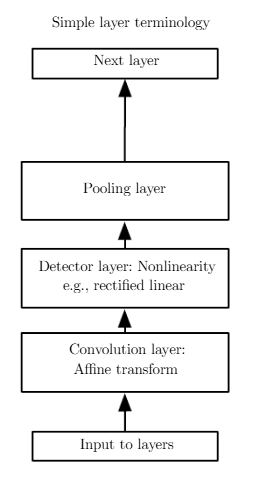

**Figura 1**: Estrutura de uma CNN tradicional. Observa-se a presença das seguintes camadas: convolução, que percorre a imagem extraindo padrões locais; camada não linear, responsável por introduzir a não linearidade no problema; e camada de pooling, que reduz a dimensão espacial dos feature maps preservando as informações mais importantes.

$\quad$Com essa breve discussão, podemos montar uma rede neural seguindo a arquitetura U-Net, mas usando uma versão simplificada. Aqui ela só terá quatro camadas principais, em que a camada de pooling não aparece explicitamente por ter seu papel cumprido quando aplicamos o `down2`, reduzindo a resolução espacial da imagem. Assim, podemos estruturá-la como mostrado abaixo.

In [ ]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.down1 = nn.Sequential(nn.Conv2d(3, 64, 3, padding=1),nn.ReLU())
        self.down2 = nn.Sequential(nn.Conv2d(64, 128, 3, stride=2, padding=1),nn.ReLU())
        self.up1 = nn.Sequential(nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),nn.ReLU())
        self.final = nn.Conv2d(128, 3, 1)

    def forward(self, x):
        x1 = self.down1(x)
        x2 = self.down2(x1)
        x = self.up1(x2)
        x = torch.cat([x, x1], dim=1)
        return torch.sigmoid(self.final(x))

## 3.3 Dados e treinamento

$\quad$Com a rede definida, já podemos treiná-la. Antes disso, entretanto, é necessário criar o dataset que será utilizado para treinar o nosso denoiser, a partir da função descrita na Seção 2. Nesse processo, adicionamos ruído gaussiano (com desvio padrão de 0,05), ruído de Poisson, além de simulações de pixels queimados e saturados. Em seguida, o dataset é dividido em três subconjuntos: 70% para treino (atualização dos pesos da rede), 15% para validação (avaliação do desempenho durante o treino) e 15% para teste (avaliação final com dados desconhecidos pela rede). A divisão é feita de forma aleatória, assegurando que os conjuntos sejam independentes entre si.

In [ ]:
# Criando o dataset
dataset = Galaxy10ArrayDataset(
    images,
    labels=labels,
    noise_std=0.05,
    use_poisson=True,
    burn_ratio=0.01,
    saturate_ratio=0.01
)


# Divisão treino/validação/teste
total_size = len(dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


$\quad$Agora podemos começar de fato o treinamento da rede. Para esse próximo bloco de código é importante definirmos o que é a função de perda (_loss function_) e o número de epochs. A função de perda basicamente quantifica a diferença entre a predição da rede e o valor correto (no caso do denoiser, a imagem limpa). Essa perda é utilizada para calcular os gradintes na etapa de backpropagation. Já os gradientes dizem à rede como ajustar os pesos visando reduzir o erro nas próximas iterações.

$\quad$O número de epochs, ou épocas, é um hiperparametro no treinamento de redes neurais que define quantas vezes a rede vai percorrer o dataset de treino para ajustar os pesos. Com isso em mente, podemos ir para o código.

Outra observação: usando a GPU:T4 do Google, e 15 epochs, esta rede leva em tono de 40 minutos para ser treinada, em que adicionamos a barra de progresso para ser possível acompanhar o estágio do treinamento.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNet().to(device)      # Modelo
criterion = nn.MSELoss()       # Função de perda (erro quadrático médio - MSE)
optimizer = optim.Adam(model.parameters(), lr=1e-4)    # Otimizador

n_epochs = 15      # Número de épocas

# Lista para armazenar os valores de validação e treinamento
loss_val = []
loss_train = []

# Treinamento
for epoch in range(n_epochs):
    model.train()
    train_loss = 0.0

    # tqdm (barra de progresso) no loop de treino
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{n_epochs} - Training", leave=False)

    for noisy, clean in loop:

        '''
        Neste for loop inicialemnte separamos as imagens ruidosas das limpas. Zeramos os gradientes
        antigos e passamos o batch pela rede. Com isso, é calculado o erro da predição em relação à
        imagem limpa. Propagamos os gradientes com `loss.backward()` e atualizamos os pesos da rede
        com `optimizer.step()`.
        '''
        noisy, clean = noisy.to(device), clean.to(device)
        optimizer.zero_grad()
        output = model(noisy)
        loss = criterion(output, clean)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        loop.set_postfix(loss=loss.item())  # mostra a loss atual

    # Calcula a média da perda e guarda na lista
    avg_train_loss = train_loss / len(train_loader)
    loss_train.append(avg_train_loss)

    model.eval()     # Valida o modelo
    val_loss = 0.0

    # tqdm no loop de validação
    loop_val = tqdm(val_loader, desc=f"Epoch {epoch+1}/{n_epochs} - Validation", leave=False)
    with torch.no_grad():
        for noisy, clean in loop_val:
            noisy, clean = noisy.to(device), clean.to(device)
            output = model(noisy)
            val_loss += criterion(output, clean).item()

    avg_val_loss = val_loss / len(val_loader)
    loss_val.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{n_epochs}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")


Epoch 1/15, Training Loss: 0.0185, Validation Loss: 0.0005


Epoch 2/15, Training Loss: 0.0003, Validation Loss: 0.0002


Epoch 3/15, Training Loss: 0.0002, Validation Loss: 0.0002


Epoch 4/15, Training Loss: 0.0002, Validation Loss: 0.0001


Epoch 5/15, Training Loss: 0.0001, Validation Loss: 0.0001


Epoch 6/15, Training Loss: 0.0001, Validation Loss: 0.0001


Epoch 7/15, Training Loss: 0.0001, Validation Loss: 0.0001


Epoch 8/15, Training Loss: 0.0001, Validation Loss: 0.0001


Epoch 9/15, Training Loss: 0.0001, Validation Loss: 0.0001


Epoch 10/15, Training Loss: 0.0001, Validation Loss: 0.0001


Epoch 11/15, Training Loss: 0.0001, Validation Loss: 0.0001


Epoch 12/15, Training Loss: 0.0001, Validation Loss: 0.0001


Epoch 13/15, Training Loss: 0.0001, Validation Loss: 0.0001


Epoch 14/15, Training Loss: 0.0001, Validation Loss: 0.0001


Epoch 15/15, Training Loss: 0.0001, Validation Loss: 0.0001


$\quad$Com a rede treinada, podemos visualizar feature maps, sendo possível ver o que a rede "enxerga" em cada camada, nos ajudando a verificar se a rede está aprendendo características imporantes do dataset de treinamento. Além disso, é possível plotar os pesos de cada camada, que correspondem aos filtros convolucionais aprendidos durante o treinamento. Neste caso, cada filtro é uma matriz 3x3 que percorre a imagem buscando padrões. Com isso, enquanto os feature maps mostram como a rede responde a uma imagem específica, os pesos mostram o que a rede aprendeu a procurar em cada camada, refletindo o conhecimento acumulando do aprendizando dos outros dados.

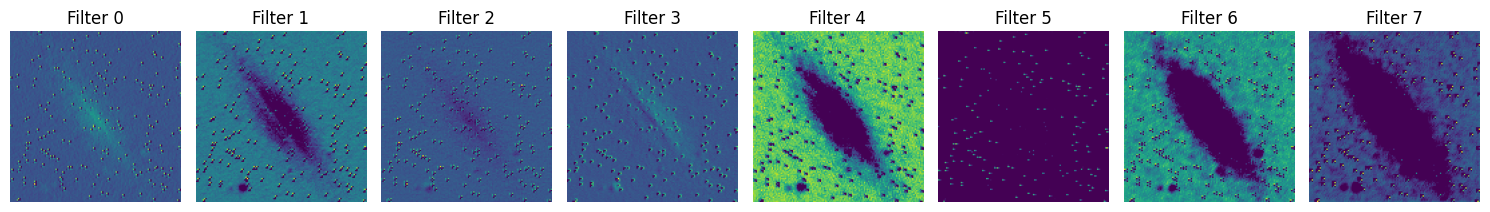

In [ ]:
noisy, _ = next(iter(test_loader))
visualize_feature_maps(model, noisy[0])

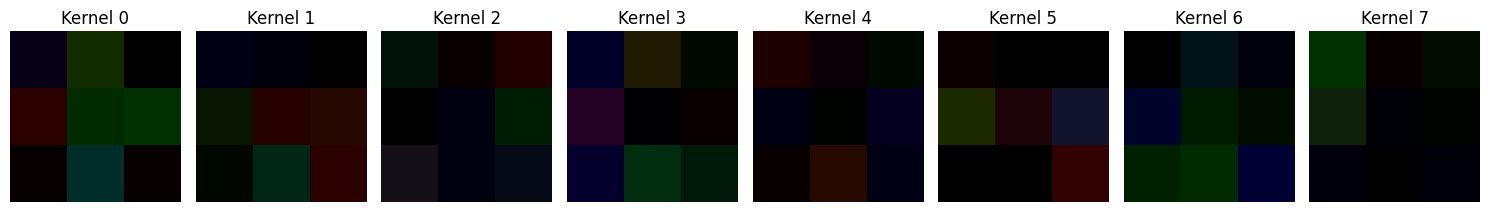

In [ ]:
plot_conv_weights(model)

$\quad$Para verificar se o treinamento está ocorrendo de forma adequada, utilizamos as listas contendo os valores da função de perda no treinamento e na validação e as comparamos. A partir do gráfico, é possível observar que ambas as perdas decaem de maneira semelhante, o que indica que o modelo está generalizando bem para os dados de validação. Um possível problema nesse estágio é a função de perda ficar presa em um mínimo local, situação em que os valores deixam de decair e passam a oscilar, sugerindo que a rede não está mais progredindo no aprendizado.

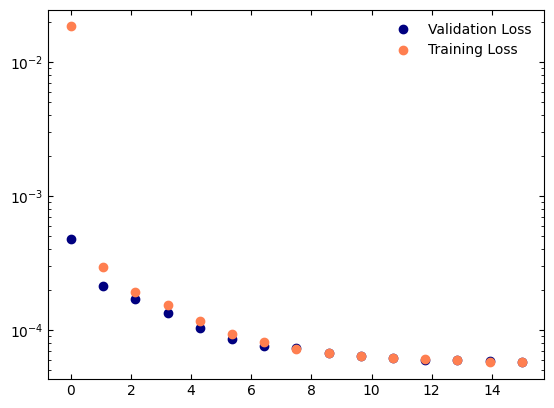

In [ ]:
x = np.linspace(0,n_epochs, n_epochs)

plt.tick_params(direction='in', which = 'both', bottom = 1, top =1, left = 1, right = 1)
plt.scatter(x,loss_val,c = 'navy', label = 'Validation Loss')
plt.scatter(x, loss_train, c = 'coral', label = 'Training Loss')
plt.yscale('log')


plt.legend(frameon=False)

$\quad$Agora podemos visualizar o resultado final do nosso denoiser. Para isso, apresentamos lado a lado a imagem com ruído sintético, a imagem resultante, a imagem original e o resíduo, que corresponde à parte do ruído removida da imagem ruidosa.

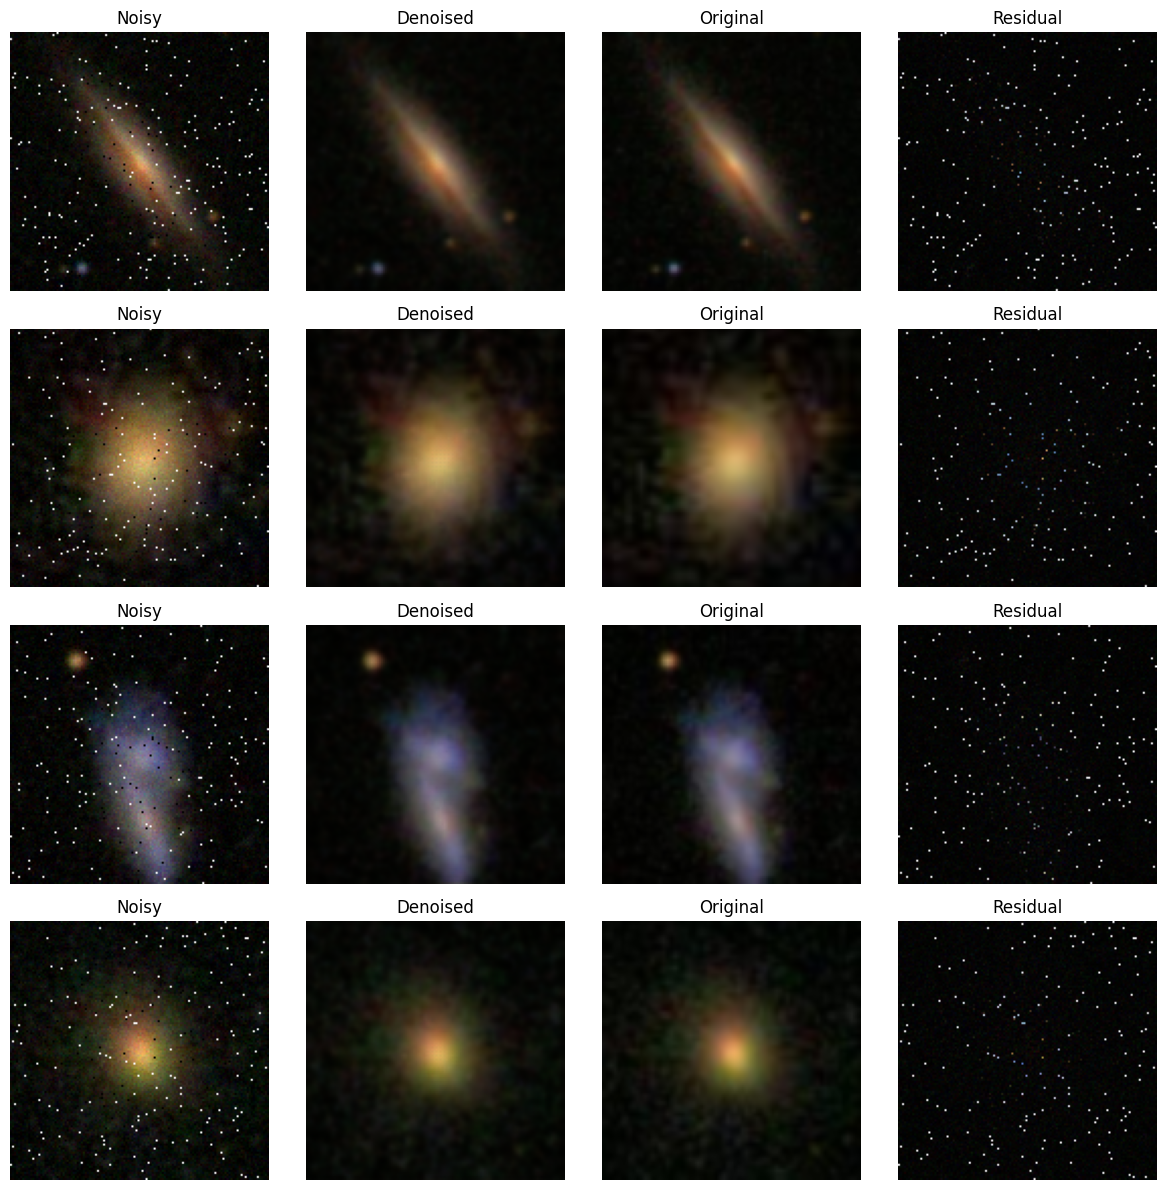

In [ ]:

def show_images(noisy, output, clean, num=4, save_path=None):
    fig, axes = plt.subplots(num, 4, figsize=(12, num * 3))
    for i in range(num):
        noisy_img = noisy[i].permute(1, 2, 0).cpu().numpy().clip(0, 1)
        output_img = output[i].permute(1, 2, 0).cpu().numpy().clip(0, 1)
        clean_img = clean[i].permute(1, 2, 0).cpu().numpy().clip(0, 1)
        residual = np.abs(noisy_img - output_img)


        axes[i, 0].imshow(noisy_img)
        axes[i, 0].set_title("Noisy")
        axes[i, 1].imshow(output_img)
        axes[i, 1].set_title("Denoised")
        axes[i, 2].imshow(clean_img)
        axes[i, 2].set_title("Original")
        axes[i, 3].imshow(residual, cmap='hot', vmin=0, vmax=0.5)
        axes[i, 3].set_title("Residual"); axes[i, 3].axis('off')

        for ax in axes[i]:
            ax.axis('off')
    plt.tight_layout()

    if save_path:
      plt.savefig(save_path, dpi=300, bbox_inches='tight')

    plt.show()

# Exibir amostras
model.eval()
noisy, clean = next(iter(test_loader))
noisy = noisy.to(device)
with torch.no_grad():
    output = model(noisy)
show_images(noisy, output, clean, save_path='painel_denoiser.png')


## 4. Estatística

$\quad$Por fim, aplicamos um método estatístico para avaliar a qualidade do produto final da rede neural construída neste `Notebook`. A métrica escolhida é o PSNR (Peak Signal-to-Noise Ratio), utilizada para quantificar a qualidade de uma imagem ou sinal reconstruído em relação a uma imagem original de referência. Basicamente, quanto menor a diferença entre a imagem processada e a original, maior será o PSNR, indicando melhor qualidade. Essa métrica mede o erro entre os pixels das duas imagens, expressando-o em uma escala logarítmica.

$\quad$Embora o PSNR não reflita perfeitamente a percepção visual humana, ele é sensível a pequenas diferenças de pixel. Valores típicos de referência são: 30–50 dB, indicando imagens de boa qualidade; e menos de 20 dB, indicando baixa qualidade.
O PSNR é calculado a partir do erro quadrático médio (MSE) entre a imagem original $I$ e a imagem processada $K$:

$$
\text{MSE} = \frac{1}{mn} \sum_{i=0}^{m-1} \sum_{j=0}^{n-1} \left[ I(i,j) - K(i,j) \right]^2
$$

Em seguida, o PSNR é definido como:

$$
\text{PSNR} = 10 \cdot \log_{10} \left( \frac{MAX_I^2}{\text{MSE}} \right)
$$

onde $MAX_I$ é o valor máximo possível de pixel (por exemplo, 255 para imagens de 8 bits). Com isso em mente, podemos implementa-lo.


In [ ]:
def psnr_batch(output, target, max_val=1.0):
    mse = torch.mean((output - target) ** 2, dim=[1, 2, 3])  # MSE para cada imagem no batch
    psnr = 10 * torch.log10(max_val**2 / mse)
    return psnr.mean().item()  # PSNR médio do batch


model.eval()
test_loss = 0
test_psnr = 0
with torch.no_grad():
    for noisy, clean in test_loader:  # note o test_loader aqui
        noisy, clean = noisy.to(device), clean.to(device)
        output = model(noisy)
        loss = criterion(output, clean)
        test_loss += loss.item()
        test_psnr += psnr_batch(output, clean)

test_loss /= len(test_loader)
test_psnr /= len(test_loader)
print(f"Test Loss: {test_loss:.5f} | Test PSNR: {test_psnr:.2f} dB")


Test Loss: 0.00006 | Test PSNR: 42.56 dB


## 5. Conclusão

$\quad$Neste `Notebook`, exploramos o uso de redes convolucionais aplicadas à astronomia observacional, com foco na construção de uma ferramenta para redução de ruído em imagens de galáxias do SDSS. Para isso, implementamos uma CNN com arquitetura U-Net simplificada, que é especialmente eficiente em tarefas de restauração de imagens devido à combinação de convoluções com operações de upsampling e skip connections, preservando detalhes espaciais importantes.

$\quad$O desempenho do modelo foi avaliado por meio de métricas de erro e de fidelidade das imagens, permitindo monitorar o aprendizado durante o treinamento. Além disso, o PSNR forneceu uma medida complementar da qualidade do produto final da rede, indicando quão próxima a imagem reconstruída estava da original.

$\quad$O comportamento da perda sugere que o treinamento ocorreu de forma estável, sem sinais de overfitting ou divergência, enquanto o PSNR médio retornou valores acima de 40 dB, indicando que as imagens reconstruídas do conjunto de teste se assemelham muito às originais.

$\quad$Em resumo, o modelo demonstrou capacidade consistente de reconstrução e produziu imagens de alta qualidade, mostrando o potencial das redes convolucionais U-Net na redução de ruído em imagens astronômicas.

## Referências

**[1]** Ronneberger, O., Fischer, P. and Brox, T. (2015). U-Net: Convolutional networks for biomedical image segmentation. arXiv (Cornell University). doi:https://doi.org/10.48550/arxiv.1505.04597;

**[2]** Fukushima, K. (1980). Neocognitron: A self-organizing neural network model for a mechanism of pattern recognition unaffected by shift in position. Biological Cybernetics, 36(4), pp.193–202. doi:https://doi.org/10.1007/bf00344251.

**[3]**Lecun, Y., Bottou, L., Bengio, Y. and Haffner, P. (2018). Gradient-based learning applied to document recognition. Proceedings of the IEEE, 86(11), pp.2278–2324.

**[4]** Goodfellow, I., Bengio, Y. and Courville, A. (2016). Deep Learning. [online] Cambridge, Massachusetts: The MIT Press. Available at: https://www.deeplearningbook.org/.


